In [20]:
pip install prettytable


[notice] A new release of pip is available: 25.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [8]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import matplotlib.pyplot as plt
import os
import cv2
import numpy as np
import shutil
import random
print("\nDONE!")


DONE!


In [10]:
# Dataset settings
dataset_path = 'Downloads/reduced_data'  # <- this should point to the folder where class-named subfolders (like 01_palm, 02_l, etc.) exist
image_size = (64, 64)     # <- set based on your model's input
batch_size = 32 
print("\nDONE!")


DONE!


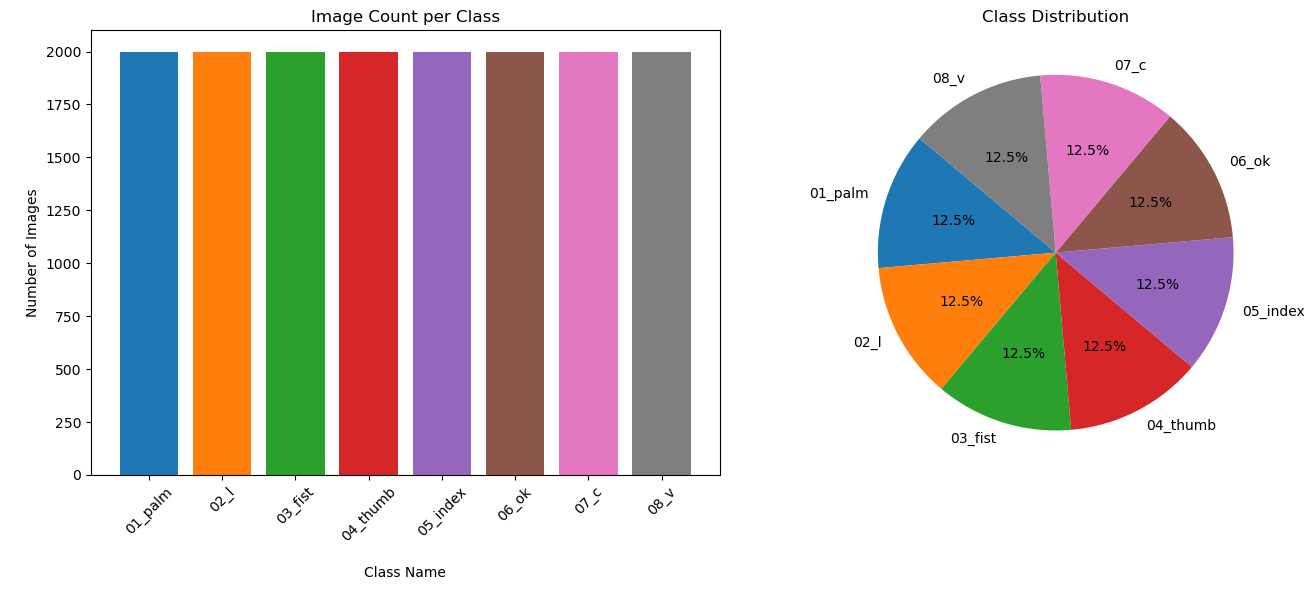

In [48]:
import os
import matplotlib.pyplot as plt
from collections import defaultdict
import seaborn as sns
import pandas as pd
# Path to dataset
dataset_path = 'Downloads/reduced_data'

# Count images per class
class_counts = defaultdict(int)

for class_name in os.listdir(dataset_path):
    class_path = os.path.join(dataset_path, class_name)
    if os.path.isdir(class_path):
        image_files = [f for f in os.listdir(class_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        class_counts[class_name] = len(image_files)

# Sort classes
sorted_classes = sorted(class_counts.items(), key=lambda x: x[0])
class_names, counts = zip(*sorted_classes)

# Generate unique colors for each bar
colors = plt.cm.tab10.colors  # Or use 'tab20', 'Set3', etc.
bar_colors = [colors[i % len(colors)] for i in range(len(class_names))]

# Plotting
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Multicolor bar chart
axs[0].bar(class_names, counts, color=bar_colors)
axs[0].set_title('Image Count per Class')
axs[0].set_xlabel('\nClass Name')
axs[0].set_ylabel('\nNumber of Images')
axs[0].tick_params(axis='x', rotation=45)

# Pie chart
axs[1].pie(counts, labels=class_names, autopct='%1.1f%%', startangle=140, colors=bar_colors)
axs[1].set_title('Class Distribution')

plt.tight_layout()
plt.show()

In [12]:
# New root directory to hold split sets
base_dir = "split_data"
train_dir = os.path.join(base_dir, "train")
val_dir = os.path.join(base_dir, "val")
test_dir = os.path.join(base_dir, "test")
print("\nDONE!")


DONE!


In [14]:
# Create the directory structure
for dir_path in [train_dir, val_dir, test_dir]:
    os.makedirs(dir_path, exist_ok=True)

# Parameters for splitting
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

# Loop through each class folder and split images
for class_name in os.listdir(dataset_path):
    class_path = os.path.join(dataset_path, class_name)
    if not os.path.isdir(class_path):
        continue

    images = os.listdir(class_path)
    random.shuffle(images)

    total = len(images)
    train_count = int(total * train_ratio)
    val_count = int(total * val_ratio)

    train_imgs = images[:train_count]
    val_imgs = images[train_count:train_count + val_count]
    test_imgs = images[train_count + val_count:]

    for split, split_imgs in zip(["train", "val", "test"], [train_imgs, val_imgs, test_imgs]):
        split_class_dir = os.path.join(base_dir, split, class_name)
        os.makedirs(split_class_dir, exist_ok=True)

        for img_name in split_imgs:
            src = os.path.join(class_path, img_name)
            dst = os.path.join(split_class_dir, img_name)
            shutil.copy(src, dst)

print("✅ Dataset successfully split into train, val, and test folders.")

✅ Dataset successfully split into train, val, and test folders.


In [15]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set image size and batch size
image_size = (64, 64)
batch_size = 32

# Rescale only
datagen = ImageDataGenerator(rescale=1./255)

# Load train, validation, and test sets

print("FOR TRAINING:-")
train_generator = datagen.flow_from_directory(
    "split_data/train",
    target_size=image_size,
    color_mode="grayscale",
    class_mode="categorical",
    batch_size=batch_size,
    shuffle=True
)
print("\nFOR VALIDATION:-")
val_generator = datagen.flow_from_directory(
    "split_data/val",
    target_size=image_size,
    color_mode="grayscale",
    class_mode="categorical",
    batch_size=batch_size,
    shuffle=True
)
print("\nFOR TESTING:-")
test_generator = datagen.flow_from_directory(
    "split_data/test",
    target_size=image_size,
    color_mode="grayscale",
    class_mode="categorical",
    batch_size=batch_size,
    shuffle=False
)

# Show label mapping
print("\nClass indices (label map):", train_generator.class_indices)

FOR TRAINING:-
Found 15563 images belonging to 8 classes.

FOR VALIDATION:-
Found 6170 images belonging to 8 classes.

FOR TESTING:-
Found 6201 images belonging to 8 classes.

Class indices (label map): {'01_palm': 0, '02_l': 1, '03_fist': 2, '04_thumb': 3, '05_index': 4, '06_ok': 5, '07_c': 6, '08_v': 7}


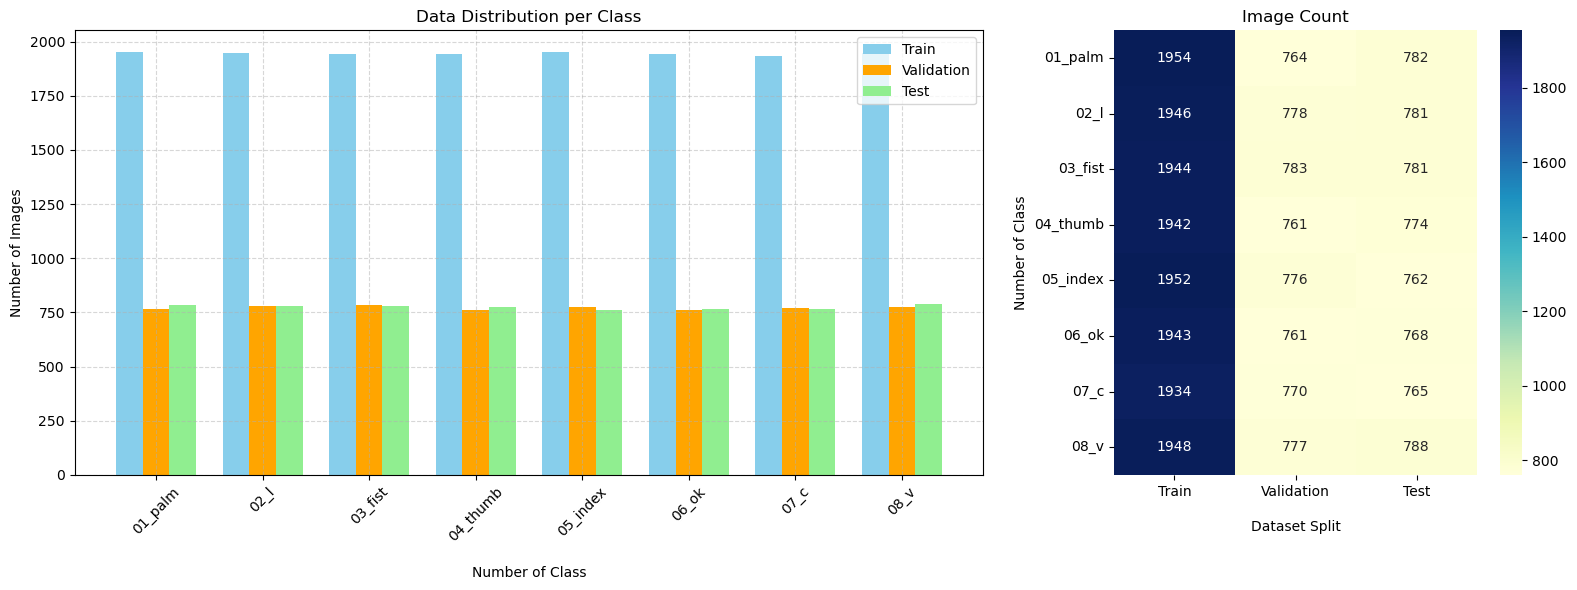

In [38]:
import matplotlib.pyplot as plt
import os
from collections import defaultdict
import numpy as np
import seaborn as sns
import pandas as pd

# Base split directories
splits = ['train', 'val', 'test']
base_split_path = 'split_data'

# Dictionary to store counts
distribution = {split: defaultdict(int) for split in splits}
all_classes = set()

# Count images in each class folder
for split in splits:
    split_path = os.path.join(base_split_path, split)
    for class_name in os.listdir(split_path):
        class_path = os.path.join(split_path, class_name)
        if os.path.isdir(class_path):
            count = len([f for f in os.listdir(class_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
            distribution[split][class_name] = count
            all_classes.add(class_name)

# Sort class names
all_classes = sorted(list(all_classes))
x = np.arange(len(all_classes))
width = 0.25

train_counts = [distribution['train'][cls] for cls in all_classes]
val_counts = [distribution['val'][cls] for cls in all_classes]
test_counts = [distribution['test'][cls] for cls in all_classes]

# Create DataFrame for heatmap
df = pd.DataFrame({
    'Train': train_counts,
    'Validation': val_counts,
    'Test': test_counts
}, index=all_classes)

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(16, 6), gridspec_kw={'width_ratios': [2, 1]})

# Bar chart
axs[0].bar(x - width, train_counts, width=width, label='Train', color='skyblue')
axs[0].bar(x, val_counts, width=width, label='Validation', color='orange')
axs[0].bar(x + width, test_counts, width=width, label='Test', color='lightgreen')
axs[0].set_xlabel('\nNumber of Class')
axs[0].set_ylabel('Number of Images')
axs[0].set_title('Data Distribution per Class')
axs[0].set_xticks(ticks=x)
axs[0].set_xticklabels(all_classes, rotation=45)
axs[0].legend()
axs[0].grid(True, linestyle='--', alpha=0.5)

# Heatmap
sns.heatmap(df, annot=True, fmt="d", cmap="YlGnBu", ax=axs[1])
axs[1].set_title("Image Count")
axs[1].set_ylabel("\nNumber of Class")
axs[1].set_xlabel("\nDataset Split")

plt.tight_layout()
plt.show()

In [21]:
# Build the CNN model

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(64, 64, 1)),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(128, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(256, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(256, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(512, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(train_generator.num_classes, activation='softmax')
])
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
print("\nDONE!")


DONE!


In [47]:
print("\nModel built successfully!")

# Print model summary
model.summary()


Model built successfully!


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 64, 64, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 4, 4, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 2, 2, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 2, 2, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 1, 1, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 8)              │         4,104 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,274,522 (27.75 MB)

 Trainable params: 2,424,840 (9.25 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 4,849,682 (18.50 MB)

In [23]:
from tensorflow.keras.callbacks import EarlyStopping

# EarlyStopping callback
early_stop = EarlyStopping(
    monitor='val_loss',     # You can also use 'val_accuracy'
    patience=5,             # Stop after 3 epochs of no improvement
    restore_best_weights=True,  # Restore the best model weights
    verbose=1
)

# Compile the model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train the model with EarlyStopping
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=15, 
    validation_data=val_generator,
    validation_steps=val_generator.samples // batch_size,
    callbacks=[early_stop]  # Add EarlyStopping callback here
)
print("\nDONE!")

Epoch 1/15
400/400 ━━━━━━━━━━━━━━━━━━━━ 230s 573ms/step - accuracy: 0.4316 - loss: 1.4140 - val_accuracy: 0.9147 - val_loss: 0.2876
Epoch 2/15
400/400 ━━━━━━━━━━━━━━━━━━━━ 235s 587ms/step - accuracy: 0.9917 - loss: 0.0320 - val_accuracy: 0.8881 - val_loss: 0.6190
Epoch 3/15
400/400 ━━━━━━━━━━━━━━━━━━━━ 235s 588ms/step - accuracy: 0.9946 - loss: 0.0210 - val_accuracy: 0.9594 - val_loss: 0.1909
Epoch 4/15
400/400 ━━━━━━━━━━━━━━━━━━━━ 234s 584ms/step - accuracy: 0.9993 - loss: 0.0033 - val_accuracy: 0.9669 - val_loss: 0.2572
Epoch 5/15
400/400 ━━━━━━━━━━━━━━━━━━━━ 256s 640ms/step - accuracy: 0.9959 - loss: 0.0199 - val_accuracy: 0.9344 - val_loss: 0.4115
Epoch 6/15
400/400 ━━━━━━━━━━━━━━━━━━━━ 233s 582ms/step - accuracy: 0.9967 - loss: 0.0168 - val_accuracy: 0.9347 - val_loss: 0.3178
Epoch 7/15
400/400 ━━━━━━━━━━━━━━━━━━━━ 233s 583ms/step - accuracy: 0.9986 - loss: 0.0071 - val_accuracy: 0.9359 - val_loss: 0.3636
Epoch 8/15
400/400 ━━━━━━━━━━━━━━━━━━━━ 272s 682ms/step - accuracy: 0.9995 -

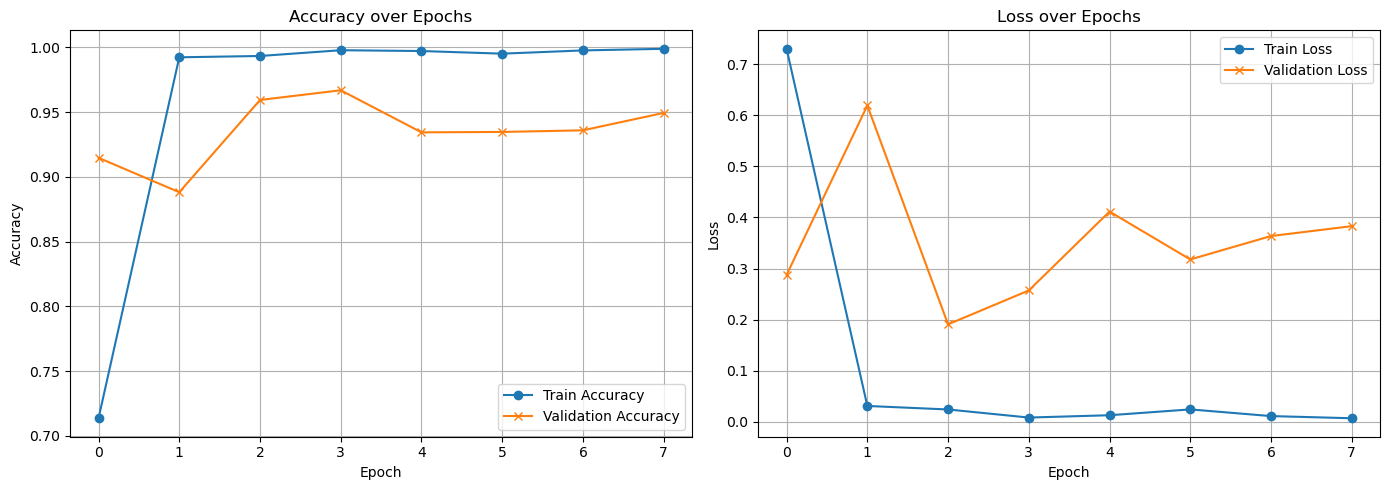

In [27]:
# Plot Learning Curves
plt.figure(figsize=(14, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='x')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='x')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [25]:
# Evaluate on validation set
val_loss, val_acc = model.evaluate(validation_generator)
print(f"\nFinal Validation Accuracy: {val_acc:.4f}, Loss: {val_loss:.4f}")

# Save the model
model.save('Hand_Gesture_model.h5')
print("\nModel saved as 'Hand_Gesture_model.h5'")

100/100 ━━━━━━━━━━━━━━━━━━━━ 44s 437ms/step - accuracy: 0.9556 - loss: 0.1733



Final Validation Accuracy: 0.9594, Loss: 0.1909

Model saved as 'Hand_Gesture_model.h5'


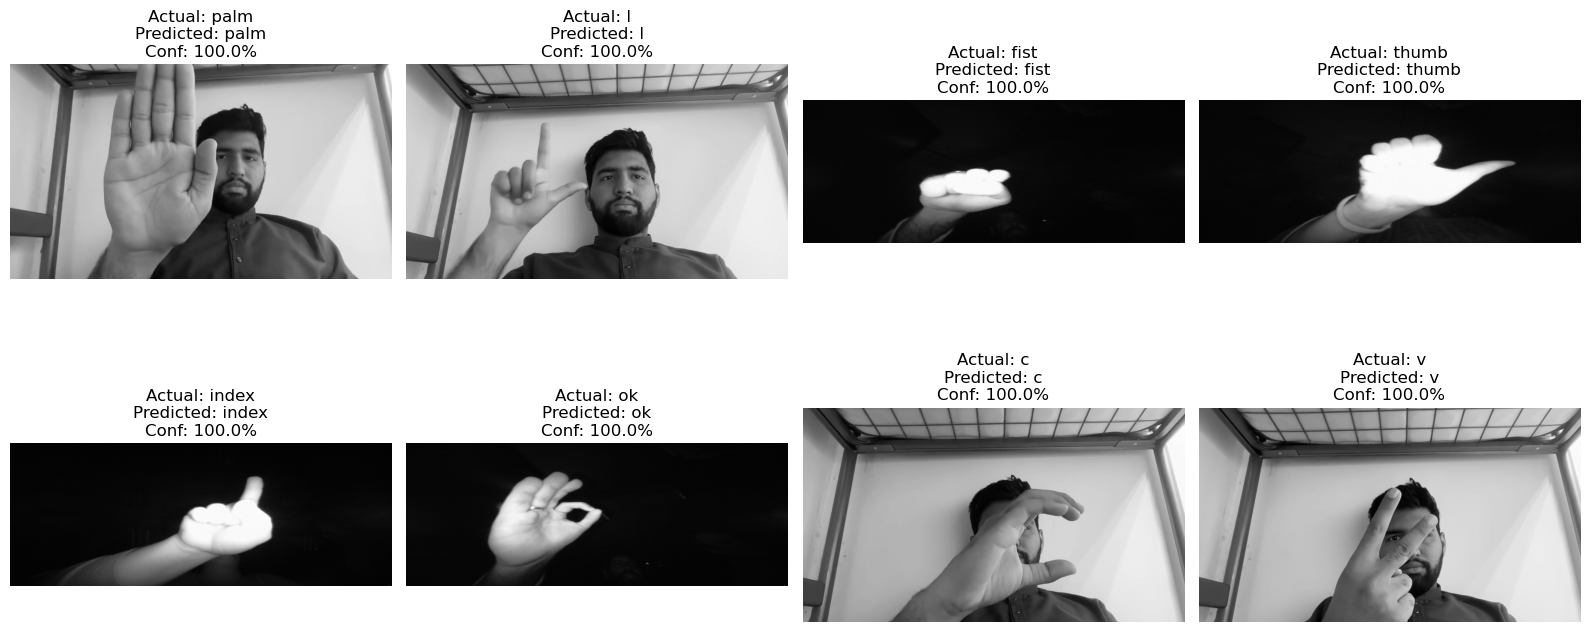

In [133]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

# Load trained model
model = load_model('Hand_Gesture_model.h5')

# Path to dataset
base_path = '/Users/muhammadahmed/Downloads/reduced_data'

# Model input settings
input_shape = model.input_shape[1:]  # e.g., (64, 64, 1)
image_size = input_shape[:2]
channels = input_shape[2]
color_mode = 'grayscale' if channels == 1 else 'rgb'

# Invert class index dictionary (replace with your actual labels if known)
# Example: {"01_palm": "palm", ...}
class_labels = {
    '01_palm': 'palm', '02_l': 'l','03_fist': 'fist','04_thumb': 'thumb','05_index': 'index', '06_ok': 'ok','07_c': 'c', '08_v': 'v'
}

# Collect random 1 image path from each class folder
image_paths = []
for folder_name in class_labels:
    folder_path = os.path.join(base_path, folder_name)
    all_images = [f for f in os.listdir(folder_path) if f.endswith('.png')]
    if not all_images:
        continue
    random_img = random.choice(all_images)
    full_path = os.path.join(folder_path, random_img)
    image_paths.append((full_path, folder_name))  # Store with actual label folder

# Plot settings
plt.figure(figsize=(16, 8))

# Loop over selected images
for i, (img_path, actual_folder) in enumerate(image_paths):
    # Load original image for display
    original_image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE if channels == 1 else cv2.IMREAD_COLOR)
    if original_image is None:
        continue

    # Convert BGR to RGB for matplotlib
    if channels == 3:
        display_img = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
    else:# Compile
resnet_model.compile(optimizer=Adam(learning_rate=0.0001),
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])

# Early stopping
early_stop_resnet = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history_resnet = resnet_model.fit(
    train_generator_resnet,
    steps_per_epoch=train_generator_resnet.samples // batch_size,
    validation_data=validation_generator_resnet,
    validation_steps=validation_generator_resnet.samples // batch_size,
    epochs=15,
    callbacks=[early_stop_resnet]
)

# Save the model
resnet_model.save('Hand_Gesture_ResNet50.h5')
        display_img = original_image

    # Prepare image for model
    img = image.load_img(img_path, target_size=image_size, color_mode=color_mode)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0

    # Predict
    prediction = model.predict(img_array, verbose=0)
    predicted_class_index = np.argmax(prediction)
    confidence = np.max(prediction)

    # Get folder name as actual label and predicted label from model
    actual_label = class_labels.get(actual_folder, actual_folder)
    predicted_label = list(class_labels.values())[predicted_class_index]

    # Plot
    plt.subplot(2, 4, i + 1)
    plt.imshow(display_img, cmap='gray' if channels == 1 else None)
    plt.axis('off')
    plt.title(f"Actual: {actual_label}\nPredicted: {predicted_label}\nConf: {confidence * 100:.1f}%")

plt.tight_layout()
plt.show()

101/101 ━━━━━━━━━━━━━━━━━━━━ 44s 436ms/step

📋 Classification Report:
              precision    recall  f1-score   support

     01_palm       0.12      0.11      0.11       400
        02_l       0.14      0.15      0.14       400
     03_fist       0.13      0.11      0.12       400
    04_thumb       0.14      0.15      0.14       400
    05_index       0.14      0.14      0.14       400
       06_ok       0.14      0.15      0.15       400
        07_c       0.12      0.12      0.12       400
        08_v       0.10      0.10      0.10       400

    accuracy                           0.13      3200
   macro avg       0.13      0.13      0.13      3200
weighted avg       0.13      0.13      0.13      3200



/opt/anaconda3/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


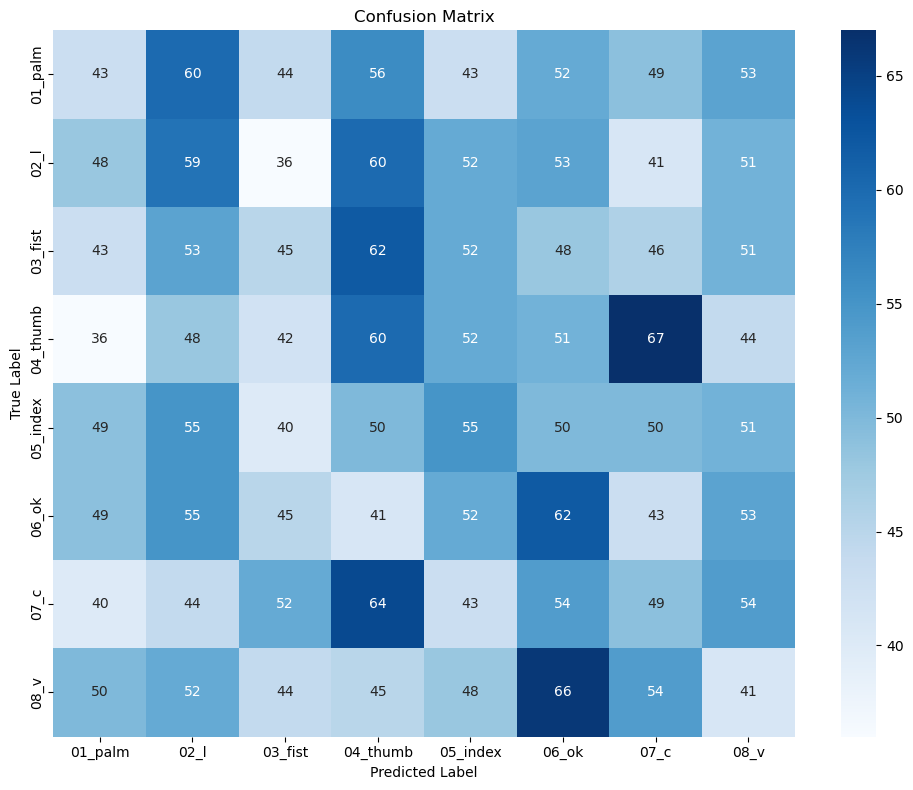


📈 Final Training Accuracy: 0.9989
📉 Final Training Loss: 0.0072
📈 Final Testing Accuracy: 0.9494
📉 Final Testing Loss: 0.3829


In [33]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import seaborn as sns
import pandas as pd


# Step 1: Get true labels and predictions from validation set
# Reset validation generator to make sure it starts from the beginning
validation_generator.reset()

# Predict labels for validation data
y_pred_probs = model.predict(validation_generator, steps=validation_generator.samples // batch_size + 1, verbose=1)
y_pred_classes = np.argmax(y_pred_probs, axis=1)

# True labels
y_true = validation_generator.classes[:len(y_pred_classes)]  # align length in case of mismatch

# Get class labels
class_names = list(validation_generator.class_indices.keys())

# Step 2: Classification report
print("\n📋 Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=class_names))

# Step 3: Confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

# Step 4: Print final training and validation accuracy/loss
train_acc = history.history['accuracy'][-1]
val_acc = history.history['val_accuracy'][-1]
train_loss = history.history['loss'][-1]
val_loss = history.history['val_loss'][-1]

print(f"\n📈 Final Training Accuracy: {train_acc:.4f}")
print(f"📉 Final Training Loss: {train_loss:.4f}")
print(f"📈 Final Testing Accuracy: {val_acc:.4f}")
print(f"📉 Final Testing Loss: {val_loss:.4f}")

In [35]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array

# Load the trained model
model = load_model('Hand_Gesture_model.h5')

# Class labels
class_labels = {0: '01_palm', 1: '02_l', 2: '03_fist', 3: '04_thumb',
                4: '05_index', 5: '06_ok', 6: '07_c', 7: '08_v'}

# Model input settings
input_shape = model.input_shape[1:3]  # e.g., (64, 64)
confidence_threshold = 0.8

# Start webcam
cap = cv2.VideoCapture(0)
print("Starting webcam for real-time prediction (hand-focused)...")

while True:
    ret, frame = cap.read()
    if not ret:
        break

    display_frame = frame.copy()

    # Convert to HSV for skin color segmentation
    hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
    lower_skin = np.array([0, 20, 70], dtype=np.uint8)
    upper_skin = np.array([20, 255, 255], dtype=np.uint8)
    mask = cv2.inRange(hsv, lower_skin, upper_skin)

    # Morphological filtering to remove noise
    kernel = np.ones((3, 3), np.uint8)
    mask = cv2.dilate(mask, kernel, iterations=4)
    mask = cv2.GaussianBlur(mask, (5, 5), 100)

    # Find contours
    contours, _ = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    if contours:
        # Get largest contour (assumed to be the hand)
        hand_contour = max(contours, key=cv2.contourArea)
        x, y, w, h = cv2.boundingRect(hand_contour)

        # Draw rectangle in green
        cv2.rectangle(display_frame, (x, y), (x + w, y + h), (0, 255, 0), 2)

        # Extract ROI (region of interest)
        hand_roi = frame[y:y + h, x:x + w]

        # Convert to grayscale
        gray = cv2.cvtColor(hand_roi, cv2.COLOR_BGR2GRAY)
        resized = cv2.resize(gray, input_shape)
        normalized = resized.astype('float32') / 255.0
        reshaped = np.expand_dims(normalized, axis=(0, -1))  # Shape: (1, h, w, 1)

        # Predict gesture
        prediction = model.predict(reshaped, verbose=0)
        pred_index = np.argmax(prediction)
        confidence = np.max(prediction)
        predicted_label = class_labels.get(pred_index, 'Unknown')

        label_text = f"Predicted: {predicted_label} ({confidence*100:.1f}%)"
        if confidence < confidence_threshold:
            label_text += " - Low Confidence ⚠️"

        # Annotate result in black text
        cv2.putText(display_frame, label_text, (x, y - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 0), 2)

        # Show model input
        cv2.imshow('Model Input (Grayscale ROI)', resized)

    # Show webcam output
    cv2.imshow('Real-Time Hand Detection and Gesture Prediction', display_frame)

    # Quit with 'q'
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release
cap.release()
cv2.destroyAllWindows()


Starting webcam for real-time prediction (hand-focused)...


In [ ]:
# VGG 16 COMPARISON:-

In [91]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam

# Use RGB mode directly
train_datagen_vgg = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

train_generator_vgg = train_datagen_vgg.flow_from_directory(
    dataset_path,
    target_size=image_size,
    batch_size=batch_size,
    color_mode='rgb',  # ✅ Load as RGB for VGG16
    class_mode='categorical',
    subset='training',
    shuffle=True
)

validation_generator_vgg = train_datagen_vgg.flow_from_directory(
    dataset_path,
    target_size=image_size,
    batch_size=batch_size,
    color_mode='rgb',
    class_mode='categorical',
    subset='validation',
    shuffle=True
)

# Load VGG16 base model
vgg_base = VGG16(weights='imagenet', include_top=False, input_shape=(64, 64, 3))
vgg_base.trainable = False

# Create full model
vgg_model = Sequential([
    vgg_base,
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(train_generator_vgg.num_classes, activation='softmax')
])

Found 12800 images belonging to 8 classes.
Found 3200 images belonging to 8 classes.


In [93]:
# Compile
vgg_model.compile(
    optimizer=Adam(),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train with early stopping
early_stop_vgg = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history_vgg = vgg_model.fit(
    train_generator_vgg,
    steps_per_epoch=train_generator_vgg.samples // batch_size,
    validation_data=validation_generator_vgg,
    validation_steps=validation_generator_vgg.samples // batch_size,
    epochs=15,
    callbacks=[early_stop_vgg]
)

# Save
vgg_model.save('Hand_Gesture_VGG16.h5')
print("\n✅ Model saved successfully as Hand_Gesture_VGG16.h5")

Epoch 1/15
400/400 ━━━━━━━━━━━━━━━━━━━━ 232s 578ms/step - accuracy: 0.7712 - loss: 0.7108 - val_accuracy: 0.9472 - val_loss: 0.1854
Epoch 2/15
400/400 ━━━━━━━━━━━━━━━━━━━━ 228s 570ms/step - accuracy: 0.9935 - loss: 0.0418 - val_accuracy: 0.9319 - val_loss: 0.1944
Epoch 3/15
400/400 ━━━━━━━━━━━━━━━━━━━━ 233s 582ms/step - accuracy: 0.9964 - loss: 0.0184 - val_accuracy: 0.9034 - val_loss: 0.2142
Epoch 4/15
400/400 ━━━━━━━━━━━━━━━━━━━━ 231s 578ms/step - accuracy: 0.9953 - loss: 0.0206 - val_accuracy: 0.9563 - val_loss: 0.1569
Epoch 5/15
400/400 ━━━━━━━━━━━━━━━━━━━━ 1129s 3s/step - accuracy: 0.9943 - loss: 0.0198 - val_accuracy: 0.9175 - val_loss: 0.2823
Epoch 6/15
400/400 ━━━━━━━━━━━━━━━━━━━━ 795s 2s/step - accuracy: 0.9969 - loss: 0.0109 - val_accuracy: 0.9372 - val_loss: 0.1973
Epoch 7/15
400/400 ━━━━━━━━━━━━━━━━━━━━ 230s 574ms/step - accuracy: 0.9983 - loss: 0.0066 - val_accuracy: 0.8969 - val_loss: 0.3173
Epoch 8/15
400/400 ━━━━━━━━━━━━━━━━━━━━ 230s 575ms/step - accuracy: 0.9883 - loss


✅ Model saved successfully as 'Hand_Gesture_VGG16.h5'


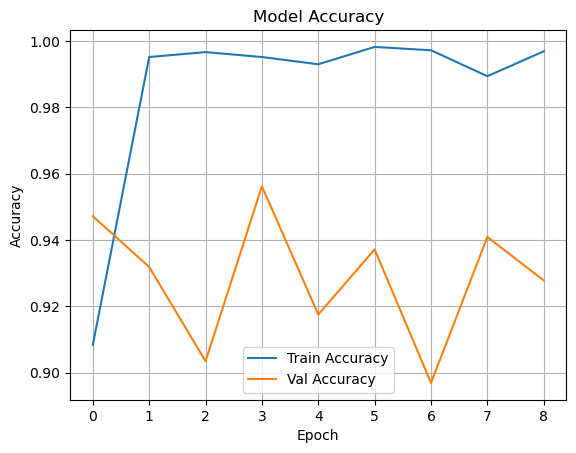

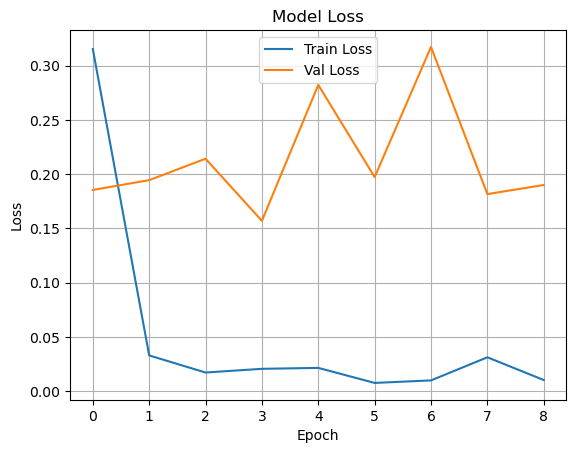

In [94]:
import matplotlib.pyplot as plt

# Accuracy
plt.plot(history_vgg.history['accuracy'], label='Train Accuracy')
plt.plot(history_vgg.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Loss
plt.plot(history_vgg.history['loss'], label='Train Loss')
plt.plot(history_vgg.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

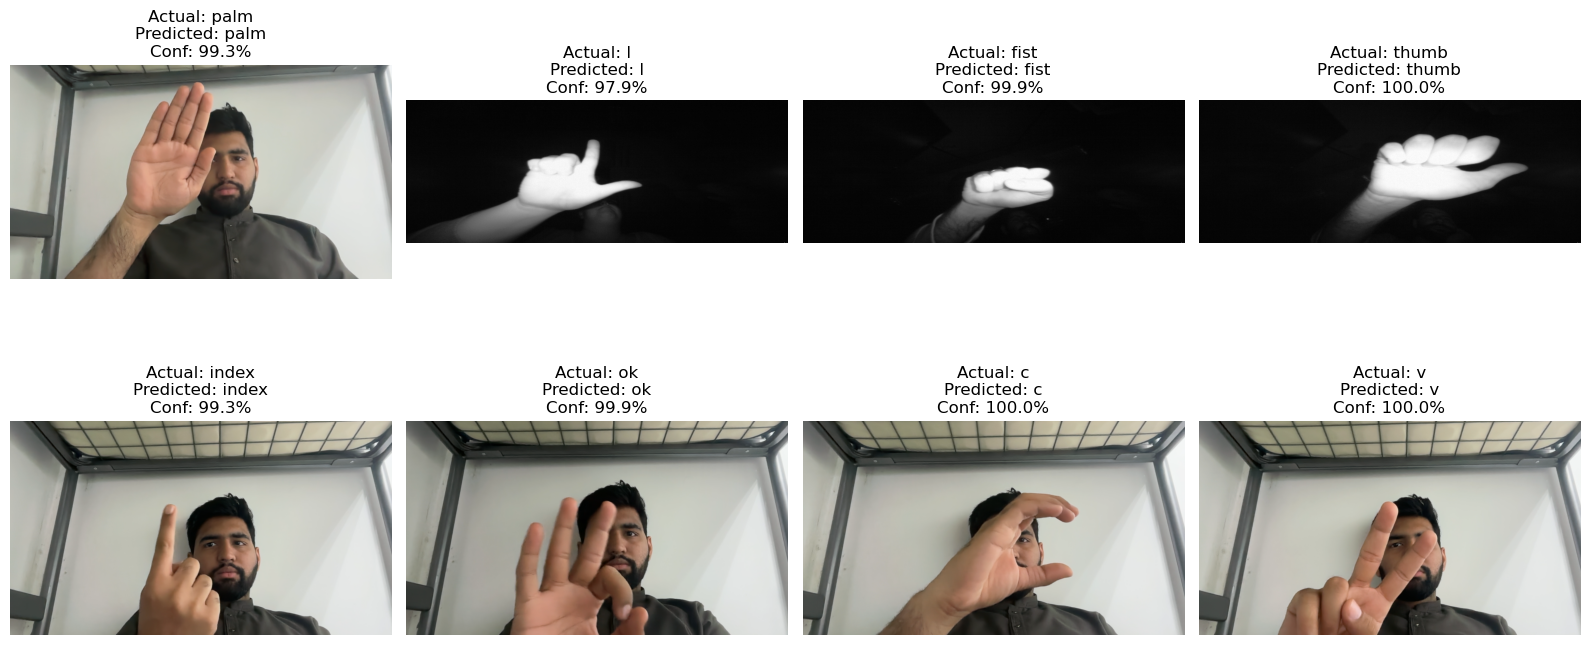

In [127]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

# Load VGG16-trained model
model = load_model('Hand_Gesture_VGG16.h5')  # Change this if your file is named differently

# Path to dataset
base_path = '/Users/muhammadahmed/Downloads/reduced_data'

# VGG16 expects RGB and 224x224 images
image_size = (64, 64)
color_mode = 'rgb'

# Update class labels (should match training order)
class_labels = {
    '01_palm': 'palm', '02_l': 'l', '03_fist': 'fist', '04_thumb': 'thumb',
    '05_index': 'index', '06_ok': 'ok', '07_c': 'c', '08_v': 'v'
}
label_list = list(class_labels.values())

# Collect 1 random image path from each class
image_paths = []
for folder_name in class_labels:
    folder_path = os.path.join(base_path, folder_name)
    all_images = [f for f in os.listdir(folder_path) if f.endswith('.png')]
    if not all_images:
        continue
    random_img = random.choice(all_images)
    full_path = os.path.join(folder_path, random_img)
    image_paths.append((full_path, folder_name))

# Plot settings
plt.figure(figsize=(16, 8))

# Loop over images
for i, (img_path, actual_folder) in enumerate(image_paths):
    # Load original image for display
    original_image = cv2.imread(img_path)
    if original_image is None:
        continue

    # Convert BGR to RGB
    display_img = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)

    # Resize and preprocess for VGG16
    img = image.load_img(img_path, target_size=image_size, color_mode=color_mode)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0  # Simple normalization

    # Predict
    prediction = model.predict(img_array, verbose=0)
    predicted_class_index = np.argmax(prediction)
    confidence = np.max(prediction)

    # Actual and predicted labels
    actual_label = class_labels.get(actual_folder, actual_folder)
    predicted_label = label_list[predicted_class_index]

    # Plot
    plt.subplot(2, 4, i + 1)
    plt.imshow(display_img)
    plt.axis('off')
    plt.title(f"Actual: {actual_label}\nPredicted: {predicted_label}\nConf: {confidence * 100:.1f}%")

plt.tight_layout()
plt.show()

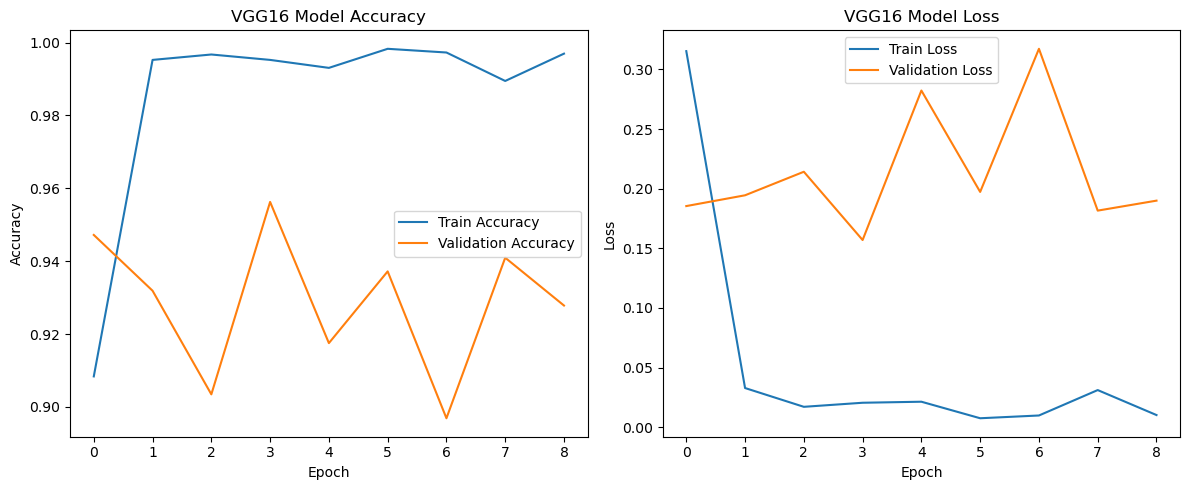

In [129]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history_vgg.history['accuracy'], label='Train Accuracy')
plt.plot(history_vgg.history['val_accuracy'], label='Validation Accuracy')
plt.title('VGG16 Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history_vgg.history['loss'], label='Train Loss')
plt.plot(history_vgg.history['val_loss'], label='Validation Loss')
plt.title('VGG16 Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

100/100 ━━━━━━━━━━━━━━━━━━━━ 47s 466ms/step


<Figure size 800x600 with 0 Axes>

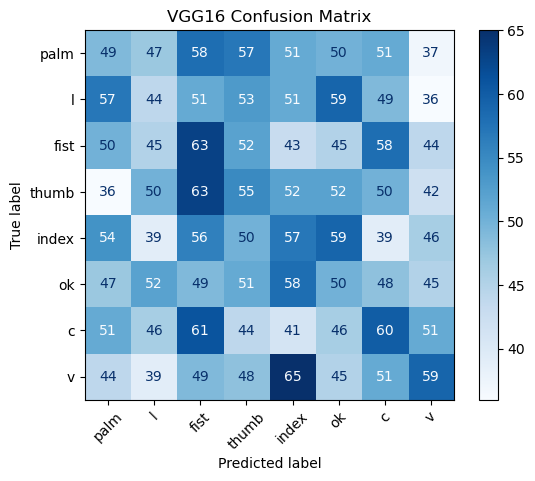

              precision    recall  f1-score   support

        palm       0.13      0.12      0.12       400
           l       0.12      0.11      0.12       400
        fist       0.14      0.16      0.15       400
       thumb       0.13      0.14      0.14       400
       index       0.14      0.14      0.14       400
          ok       0.12      0.12      0.12       400
           c       0.15      0.15      0.15       400
           v       0.16      0.15      0.16       400

    accuracy                           0.14      3200
   macro avg       0.14      0.14      0.14      3200
weighted avg       0.14      0.14      0.14      3200



In [131]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import numpy as np

# Get true labels and predictions
true_labels = validation_generator_vgg.classes
pred_probs = model.predict(validation_generator_vgg, verbose=1)
pred_labels = np.argmax(pred_probs, axis=1)

# Confusion matrix
cm = confusion_matrix(true_labels, pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_list)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title('VGG16 Confusion Matrix')
plt.show()

# Optional: print classification report
print(classification_report(true_labels, pred_labels, target_names=label_list))

In [ ]:
#ResNet50 COMPARISON

In [144]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Adjusted image size for InceptionV3
image_size = (224, 224)
batch_size = 32

# Data generators
train_datagen_incep = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

train_generator_incep = train_datagen_incep.flow_from_directory(
    dataset_path,
    target_size=image_size,
    batch_size=batch_size,
    color_mode='rgb',
    class_mode='categorical',
    subset='training',
    shuffle=True
)

validation_generator_incep = train_datagen_incep.flow_from_directory(
    dataset_path,
    target_size=image_size,
    batch_size=batch_size,
    color_mode='rgb',
    class_mode='categorical',
    subset='validation',
    shuffle=True
)

# Load InceptionV3 base model
inception_base = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
inception_base.trainable = False  # Freeze base model

# Build full model
inception_model = Sequential([
    inception_base,
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(train_generator_incep.num_classes, activation='softmax')
])

# Compile model
inception_model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Summary
inception_model.summary()

Found 12800 images belonging to 8 classes.
Found 3200 images belonging to 8 classes.
87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ inception_v3 (Functional)       │ (None, 5, 5, 2048)     │    21,802,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 51200)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 512)            │    26,214,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 8)              │         4,104 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 48,021,800 (183.19 MB)

 Trainable params: 26,219,016 (100.02 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

In [146]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop_incep = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history_incep = inception_model.fit(
    train_generator_incep,
    steps_per_epoch=train_generator_incep.samples // batch_size,
    validation_data=validation_generator_incep,
    validation_steps=validation_generator_incep.samples // batch_size,
    epochs=15,
    callbacks=[early_stop_incep]
)

# Save model
inception_model.save('Hand_Gesture_InceptionV3.h5')

Epoch 1/15
400/400 ━━━━━━━━━━━━━━━━━━━━ 260s 645ms/step - accuracy: 0.8483 - loss: 0.7795 - val_accuracy: 0.8997 - val_loss: 0.2678
Epoch 2/15
400/400 ━━━━━━━━━━━━━━━━━━━━ 254s 635ms/step - accuracy: 0.9908 - loss: 0.0265 - val_accuracy: 0.9172 - val_loss: 0.3779
Epoch 3/15
400/400 ━━━━━━━━━━━━━━━━━━━━ 253s 631ms/step - accuracy: 0.9874 - loss: 0.0368 - val_accuracy: 0.9291 - val_loss: 0.2180
Epoch 4/15
400/400 ━━━━━━━━━━━━━━━━━━━━ 255s 637ms/step - accuracy: 0.9915 - loss: 0.0239 - val_accuracy: 0.9206 - val_loss: 0.5260
Epoch 5/15
400/400 ━━━━━━━━━━━━━━━━━━━━ 256s 639ms/step - accuracy: 0.9891 - loss: 0.0380 - val_accuracy: 0.9419 - val_loss: 0.1600
Epoch 6/15
400/400 ━━━━━━━━━━━━━━━━━━━━ 258s 643ms/step - accuracy: 0.9956 - loss: 0.0143 - val_accuracy: 0.9278 - val_loss: 0.2831
Epoch 7/15
400/400 ━━━━━━━━━━━━━━━━━━━━ 259s 646ms/step - accuracy: 0.9962 - loss: 0.0130 - val_accuracy: 0.9172 - val_loss: 0.3113
Epoch 8/15
400/400 ━━━━━━━━━━━━━━━━━━━━ 260s 650ms/step - accuracy: 0.9926 -

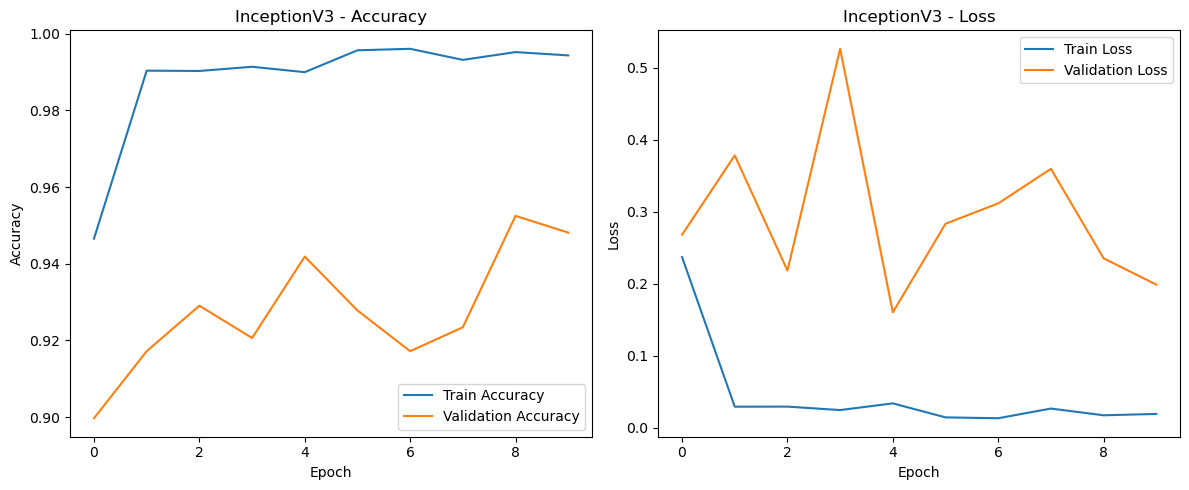

In [148]:
import matplotlib.pyplot as plt

# Plot Accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_incep.history['accuracy'], label='Train Accuracy')
plt.plot(history_incep.history['val_accuracy'], label='Validation Accuracy')
plt.title('InceptionV3 - Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history_incep.history['loss'], label='Train Loss')
plt.plot(history_incep.history['val_loss'], label='Validation Loss')
plt.title('InceptionV3 - Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [150]:
# Evaluate final model performance
val_loss, val_accuracy = inception_model.evaluate(validation_generator_incep)
print(f"Testing Accuracy: {val_accuracy * 100:.2f}%")


100/100 ━━━━━━━━━━━━━━━━━━━━ 53s 522ms/step - accuracy: 0.9462 - loss: 0.1549
Testing Accuracy: 94.19%


100/100 ━━━━━━━━━━━━━━━━━━━━ 56s 546ms/step


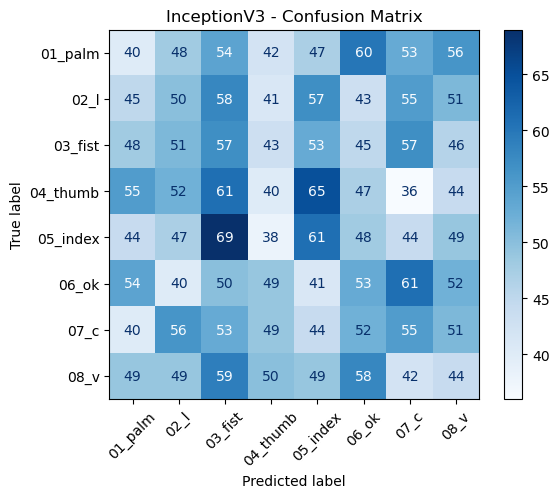

              precision    recall  f1-score   support

     01_palm       0.11      0.10      0.10       400
        02_l       0.13      0.12      0.13       400
     03_fist       0.12      0.14      0.13       400
    04_thumb       0.11      0.10      0.11       400
    05_index       0.15      0.15      0.15       400
       06_ok       0.13      0.13      0.13       400
        07_c       0.14      0.14      0.14       400
        08_v       0.11      0.11      0.11       400

    accuracy                           0.12      3200
   macro avg       0.12      0.12      0.12      3200
weighted avg       0.12      0.12      0.12      3200



In [151]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Get true labels and predictions
y_true = validation_generator_incep.classes
y_pred_probs = inception_model.predict(validation_generator_incep)
y_pred = np.argmax(y_pred_probs, axis=1)

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=validation_generator_incep.class_indices.keys())
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("InceptionV3 - Confusion Matrix")
plt.show()

# Classification report
print(classification_report(y_true, y_pred, target_names=validation_generator_incep.class_indices.keys()))

In [ ]:
# COMPARION BETWEEN CNN, VGG16 and InceptionV3

Found 3200 images belonging to 8 classes.
Found 3200 images belonging to 8 classes.
Found 3200 images belonging to 8 classes.
Model Comparison:
CNN         - Accuracy: 0.9594, Loss: 0.1909
VGG16       - Accuracy: 0.9563, Loss: 0.1569
InceptionV3 - Accuracy: 0.9419, Loss: 0.1600


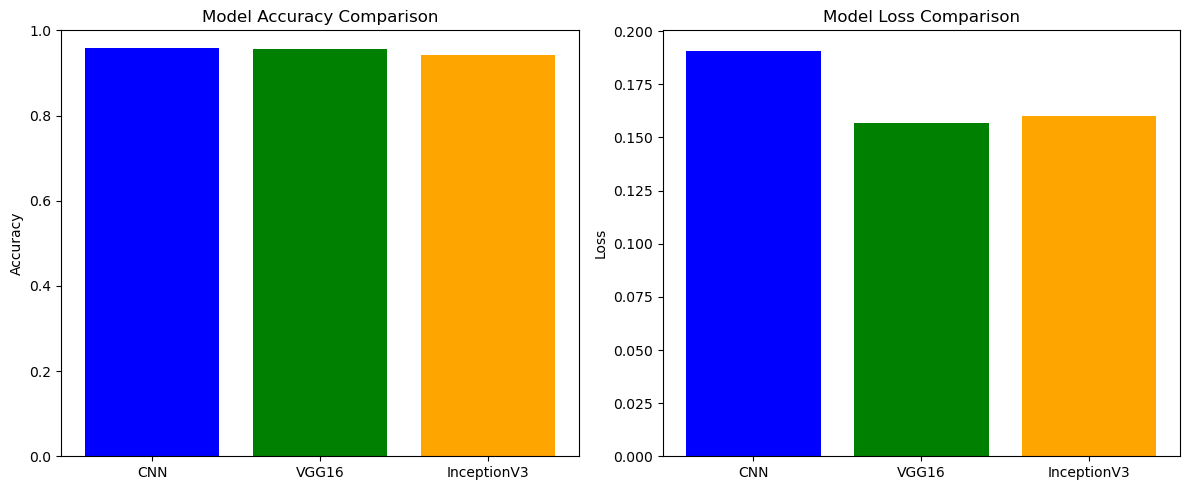

In [160]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

# Load models
cnn_model = load_model('Hand_Gesture_model.h5')
vgg_model = load_model('Hand_Gesture_VGG16.h5')
inception_model = load_model('Hand_Gesture_InceptionV3.h5')

dataset_path = '/Users/muhammadahmed/Downloads/reduced_data'
batch_size = 32

# === CNN generator (64x64x1) ===
cnn_gen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
cnn_val_gen = cnn_gen.flow_from_directory(
    dataset_path,
    target_size=(64, 64),
    color_mode='grayscale',
    class_mode='categorical',
    batch_size=batch_size,
    subset='validation',
    shuffle=False
)

# === VGG16 generator (64x64x3) — modified VGG16 ===
vgg_gen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
vgg_val_gen = vgg_gen.flow_from_directory(
    dataset_path,
    target_size=(64, 64),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=batch_size,
    subset='validation',
    shuffle=False
)

# === InceptionV3 generator (224x224x3) ===
inception_gen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
inception_val_gen = inception_gen.flow_from_directory(
    dataset_path,
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=batch_size,
    subset='validation',
    shuffle=False
)

# === Evaluate each model ===
cnn_loss, cnn_acc = cnn_model.evaluate(cnn_val_gen, verbose=0)
vgg_loss, vgg_acc = vgg_model.evaluate(vgg_val_gen, verbose=0)
inception_loss, inception_acc = inception_model.evaluate(inception_val_gen, verbose=0)

In [50]:
# Converting into HTML file
!jupyter nbconvert --to html --output "AI.html" "Artificial Intelligence.ipynb"

[NbConvertApp] Converting notebook Artificial Intelligence.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 13 image(s).
[NbConvertApp] Writing 2665140 bytes to AI.html
